In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyesg 
import  evaluation as eval
import preproccessing as prep 

In [2]:
acwi_prices = pd.read_excel('msci_acwi_net_30.10.23.xlsx')
acwi_prices.index = pd.DatetimeIndex(acwi_prices['Date'])
acwi_prices = acwi_prices['ACWI Standard Net (Large+Mid Cap)']
acwi_returns = prep.log_returns(acwi_prices)

<AxesSubplot:xlabel='Date'>

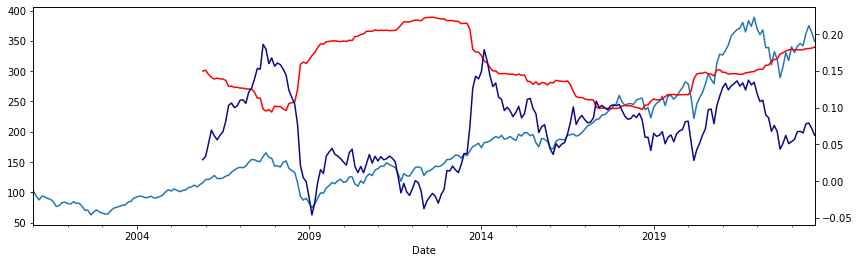

In [3]:
fig, ax1 = plt.subplots()
acwi_prices.plot(ax=ax1, figsize=(14,4))
ax2 = ax1.twinx()
(acwi_returns.rolling(60).std()*np.sqrt(12)).plot(ax=ax2, colormap='autumn')
(acwi_returns.rolling(60).mean()*12).plot(ax=ax2, colormap='plasma')

In [4]:
def asset_stats(returns, periods):
    summary = []

    for period in periods:
        summary.append(prep.assets_performance(acwi_returns[period[0]:period[1]]))

    return pd.DataFrame(data=summary, index=periods)

periods = [('2001-01-31', '2023-09-30'),
           ('2001-01-31', '2019-12-31'), 
           ('2000-08-31', '2023-07-31'),
           ('2003-03-31', '2020-03-31'),
           ('2003-03-31', '2022-12-31'),
           ('2009-02-28', '2022-12-31'),
           ('2007-10-31', '2022-12-31'),
           ('2007-10-31', '2015-05-30')
           ]


asset_stats(acwi_returns,periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(2001-01-31, 2023-09-30)",0.055009,0.160995,-0.856140,2.121958,0.538119,-0.549231
"(2001-01-31, 2019-12-31)",0.054624,0.154934,-0.987229,2.835527,0.550549,-0.549231
"(2000-08-31, 2023-07-31)",0.058540,0.161136,-0.874261,2.159978,0.613556,-0.549231
"(2003-03-31, 2020-03-31)",0.072407,0.154143,-1.182134,3.763084,0.953037,-0.549231
"(2003-03-31, 2022-12-31)",0.080425,0.157982,-0.983730,2.908463,1.105673,-0.549231
"(2009-02-28, 2022-12-31)",0.104803,0.154169,-0.435559,0.801444,1.680774,-0.256253
"(2007-10-31, 2022-12-31)",0.045327,0.172403,-0.860163,2.140233,0.307968,-0.549231
"(2007-10-31, 2015-05-30)",0.028687,0.187189,-1.004988,2.562275,-0.024306,-0.549231


<AxesSubplot:xlabel='ACWI Standard Net (Large+Mid Cap)', ylabel='Probability'>

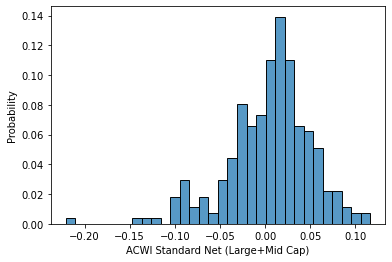

In [5]:
sns.histplot(data=acwi_returns, bins=32, stat='probability')

In [6]:
gbm_std = 0.155
gbm_mean = 0.5*gbm_std**2 + 0.072
gbm_mean

0.08401249999999999

In [7]:
number_of_scenarios = 50000
number_of_steps = 50
model = pyesg.GeometricBrownianMotion(mu=0.072,sigma=0.217)
scenarios = model.scenarios(349,1,number_of_scenarios,number_of_steps)
scenarios_df = pd.DataFrame(data=scenarios, index=range(0,number_of_scenarios), columns=range(0,number_of_steps+1))

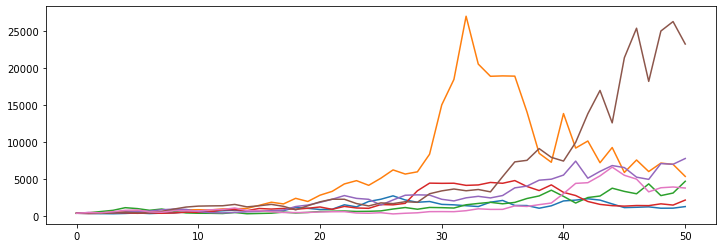

In [8]:
eval.sample_paths(scenarios,7)

,1,2,3,5,10,15,20,50
1,0.632520,0.537630,0.480118,0.415984,0.329799,0.287697,0.274004,0.323771
5,0.734247,0.664227,0.621561,0.575509,0.523853,0.519925,0.534248,0.918783
25,0.904834,0.891034,0.895073,0.915605,1.016930,1.165805,1.365957,3.999606
50,1.048280,1.100465,1.154834,1.269518,1.621911,2.078090,2.638478,11.388217
75,1.212423,1.348767,1.483047,1.761066,2.577531,3.656955,5.091977,31.843700
95,1.490193,1.820071,2.135354,2.816871,4.991605,8.197222,13.068891,143.903523
99,1.730593,2.237725,2.755742,3.899850,8.071958,14.746271,25.527390,393.675919


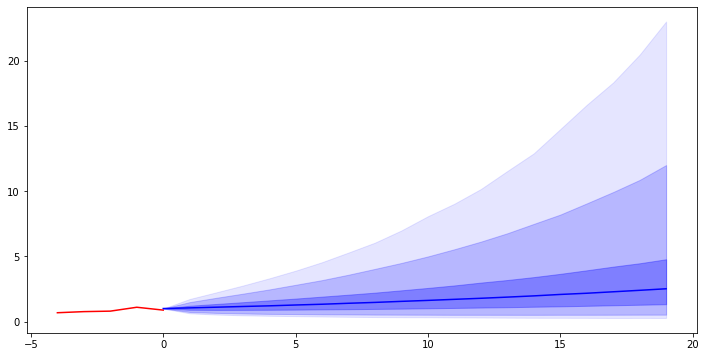

In [9]:
start_value = 349.54
eval.fanchart(acwi_prices[-60::12]/start_value,scenarios[:,:20]/start_value)
eval.percentile_summary(scenarios_df/start_value)

In [10]:
np.array([2.06,3.3,5.28]) *1000

array([2060., 3300., 5280.])

In [11]:
scenarios_returns = prep.log_returns(scenarios_df.T)
eval.describe_scenarios_vertically(scenarios_returns, data_freq='y')

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.048597,0.215951,0.000010,-0.003722,2.587478,-0.589053
std,0.030651,0.021775,0.335181,0.657003,1.750551,0.143947
min,-0.094937,0.124925,-1.891189,-1.379907,-5.713360,-0.994638
25%,0.027755,0.200990,-0.219135,-0.457290,1.400628,-0.691736
50%,0.048683,0.215612,-0.002511,-0.126334,2.564305,-0.583621
75%,0.069248,0.230427,0.218718,0.310409,3.743953,-0.483234
max,0.181516,0.305995,1.544111,6.029646,11.726269,-0.171637


<AxesSubplot:ylabel='Probability'>

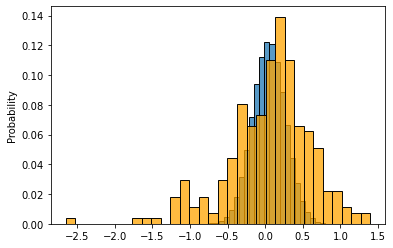

In [12]:
fig, ax1 = plt.subplots()
sns.histplot((scenarios_returns.to_numpy()).reshape(scenarios_returns.shape[0]*scenarios_returns.shape[1]),stat='probability', bins=32, ax=ax1)
sns.histplot((acwi_returns.to_numpy()*12),stat='probability', bins=32, ax=ax1, color='orange')

In [13]:
import gbm_gibbs as gibs

sampler = gibs.GibsSamplerGBM(acwi_returns['2003-03-31':'2020-03-31'],0.38)
sampler.run()
mu = sampler.mu_dist
sig = sampler.sigma_dist
print(pd.Series(mu*12, name='mu').describe())
print(pd.Series(sig * np.sqrt(12), name='sigma').describe())


count    10001.000000
mean         0.072394
std          0.001062
min          0.000000
25%          0.072251
50%          0.072412
75%          0.072567
max          0.073323
Name: mu, dtype: float64
count    10001.000000
mean         0.217548
std          0.012430
min          0.000000
25%          0.213684
50%          0.217184
75%          0.220947
max          1.316359
Name: sigma, dtype: float64


In [25]:
acwi_level_price = pd.read_excel('msci_acwi_price_10.23.xlsx',index_col='Date')
acwi_p_returns = prep.log_returns(acwi_level_price)
acwi_p_returns.index = pd.DatetimeIndex(acwi_p_returns.index)

In [26]:
acwi_p_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 429 entries, 1988-01-29 to 2023-09-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   429 non-null    float64
dtypes: float64(1)
memory usage: 6.7 KB


In [32]:
acwi_returns.name

'ACWI Standard Net (Large+Mid Cap)'

In [33]:
dividend = acwi_returns['ACWI Standard Net (Large+Mid Cap)'] - acwi_p_returns.loc['2001-01-01':]

KeyError: 'ACWI Standard Net (Large+Mid Cap)'

In [28]:
dividend.describe()

,2001-01-31 00:00:00,2001-02-28 00:00:00,2001-03-30 00:00:00,2001-04-30 00:00:00,2001-05-31 00:00:00,2001-06-29 00:00:00,2001-07-31 00:00:00,2001-08-31 00:00:00,2001-09-28 00:00:00,2001-10-31 00:00:00,...,2023-01-31 00:00:00,2023-02-28 00:00:00,2023-03-31 00:00:00,2023-04-28 00:00:00,2023-05-31 00:00:00,2023-06-30 00:00:00,2023-07-31 00:00:00,2023-08-31 00:00:00,2023-09-29 00:00:00,Price
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
